### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

## Setting up the environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ekphrasis

     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 184kB 14.4MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-cp37-none-any.whl size=82844 sha256=2681073c57b70a5e88837b5699b280d8f3c6facbc38a80ba8bb6f1121eac679c
  Stored in directory: /root/.cache/pip/wheels/2f/c5/9b/c9b60f535a2cf9fdbc92d84c4801a010c35a9cd348011ed2a1
  Created wheel for ftfy: filename=ftfy-5.9-cp37-none-any.whl size=46451 sha256=9e077d0553e41bffa0a7186bd579754bbccec5209f375052a00c7f8f151c463f
  Stored in directory: /root/.cache/pip/wheels/5e/2e/f0/b07196e8c929114998f0316894a61c752b63bfa3fdd50d2fc3
Successfully built ekphrasis ftfy


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 18.8MB/s 
     |████████████████████████████████| 3.2MB 50.8MB/s 
     |████████████████████████████████| 890kB 53.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=bd98a788eebf74ade75f52a7c2ef9edbf3b3a74a118be574f8483640c52d25c2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180944 sha256=ba2e989b7970f3d8296e3149521c027069dbcfccebd7943a5d043c8a7e0500f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-7pc0f7pi/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


## Setting up the notebook

In [ ]:
# Imports

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import codecs
import re
import spacy
import nltk
import torch.nn.functional as F

from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from torch.utils.data import Dataset, random_split
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from transformers import BertForSequenceClassification, BertTokenizer

In [ ]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = "cpu" #torch.device("cuda:0" if use_cuda else "cpu")

## Loading the data

In [ ]:
# Load data
train_df = pd.read_csv('/content/drive/MyDrive/data/task-1/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/data/task-1/dev (1).csv')

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
train_df.head()

,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0


In [ ]:
train_df['original'][0]

'France is ‘ hunting down its citizens who joined <Isis/> ’ without trial in Iraq'

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9652 entries, 0 to 9651
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         9652 non-null   int64  
 1   original   9652 non-null   object 
 2   edit       9652 non-null   object 
 3   grades     9652 non-null   int64  
 4   meanGrade  9652 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 377.2+ KB


In [ ]:
test_df.head()

,id,original,edit,grades,meanGrade
0,1723,Thousands of gay and bisexual <men/> convicted...,swans,22100,1.0
1,12736,Special <prosecutor/> appointed to Trump Russia,chef,21100,0.8
2,12274,Spanish police detain man and search Ripoll ad...,squad,21000,0.6
3,8823,N.Y. Times <reprimands/> reporter for sharing ...,applauds,32210,1.6
4,5087,Vladimir Putin Releases Video Simulation Of Ru...,balloon,11000,0.4


## Data cleaning and pre-processing

In [ ]:
def capitalisation_by_ner(sentence, entities=['GPE', 'ORG', 'NORP', 'PERSON']):
    edited_row = []

    trial_doc = nlp(sentence)
        
    for tok in trial_doc:
        if tok.ent_type_ in entities:
            edited_row.append(tok.text)
        else:
            edited_row.append(tok.text.lower())
    
    return ' '.join(edited_row)

In [ ]:
# Word replacement
# Join the contractions
# Tokenize
# remove stop words
# remove punct EXCEPT ! ? #
# Twitter handles

def preprocessor(df):
    _df = pd.DataFrame(index=df.index, columns=['edited_sentences', 'meanGrade'])

    _df['meanGrade'] = df.meanGrade

    text_processor = TextPreProcessor(
        fix_html=True,  # fix HTML tokens

        # corpus from which the word statistics are going to be used 
        # for word segmentation 
        segmenter="english", 

        # corpus from which the word statistics are going to be used 
        # for spell correction
        corrector="english", 

        unpack_hashtags=False,  # perform word segmentation on hashtags
        unpack_contractions=False,  # Unpack contractions (can't -> can not)
        spell_correct=True,  # spell correction for elongated words
    )
    
    punct = "[\.,:;\(\)\[\]@\-\$£]"
    
    nltk.download('stopwords')
    stops = stopwords.words('english')

    # Word replacement + join the contractions
    # NOTE: need to deal with ' '
    # NOTE: Numbers/digits have not been removed
    # NOTE: We have removed all stop words. We analysed the sentiment of the stop 
    # words in the training set to determine if removing them would negatively 
    # affect our results. The motivation for this check was that any word with a 
    # sentiment would affect the funniness score of the sentence. 
    # Since stop words have no sentiment, they have been removed
    # This doesn't retain any twitter handles, but retains the hashtags

    _df['edited_sentences'] = df[['original', 'edit']] \
        .apply(lambda x: re.subn("<.*/>", x[1], x[0])[0], axis=1) \
        .apply(lambda x: capitalisation_by_ner(x)) \
        .str.replace(" (?P<one>\w*'\w+)", lambda x: x.group("one")) \
        .apply(lambda x: text_processor.pre_process_doc(x)) \
        .str.replace("#", "# ") \
        .str.replace("[‘’]", "'") \
        .str.replace("'s", "") \
        .str.replace(punct, "") \
        .apply(lambda x: " ".join([w for w in x.split(" ") if w not in stops])) \
        .str.replace("[0-9]", "")

    return _df

## Setting up training and evaluation methods

In [ ]:
# Number of epochs
epochs = 10

# Proportion of training data for train compared to dev
train_proportion = 0.9

In [ ]:
# We evaluate performance on our dev set

def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            item_dict = batch
            feature, target = item_dict['input_ids'], item_dict['labels']

            feature, target = feature.to(device), target.to(device)
            # print(feature)

            # for RNN:
            # model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            # model.hidden = model.init_hidden()
            model = model.to(device)

            predictions = model(feature)
            predictions = predictions.logits.squeeze(1).to(device)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [ ]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [ ]:
class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.x_train.items()}
        item['labels'] = torch.tensor(self.y_train[idx], dtype=torch.float)
        return item

## Preparing the data

In [ ]:
clean_train_df = preprocessor(train_df)
clean_test_df = preprocessor(test_df)

Reading english - 1grams ...


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Reading english - 1grams ...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
## Approach 1 code, using functions defined above:

# We set our training data and test data
training_data = clean_train_df['edited_sentences']
test_data = clean_test_df['edited_sentences']

# Creating word vectors
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [ ]:
train_X = tokenizer(training_data.to_list(), add_special_tokens=False, padding=True, return_tensors="pt")

In [ ]:
train_dataset = Task1Dataset(train_X, train_df['meanGrade'])

## Initialising and training the model

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
print("Model initialised.")

model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model initialised.


In [ ]:
train_examples = round(len(train_dataset)*train_proportion)
dev_examples = len(train_dataset) - train_examples

train_dataset, dev_dataset = random_split(train_dataset,
                                           (train_examples,
                                            dev_examples))
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())


Dataloaders created.


In [ ]:
from transformers import EvalPrediction

def evaluation_metric(eval_prediction):
  predictions = eval_prediction.predictions
  target = eval_prediction.label_ids
  pred, trg = predictions, target
  sse, mse = model_performance(pred, trg, print_output=True)
  return {"sse": str(sse), "mse": str(mse), "rmse": str(mse ** 0.5)}

In [ ]:
from transformers import Trainer, TrainingArguments
epochs=2
lr = 3e-5

training_args = TrainingArguments(
    output_dir=f'./results_ep{epochs}_lr{str(lr)}',          # output directory
    num_train_epochs=epochs,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir=f'./logs_ep{epochs}_lr{str(lr)}',            # directory for storing logs
    logging_steps=1,
    evaluation_strategy="steps",
    learning_rate=lr,
    eval_steps=50
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,             # evaluation dataset
    compute_metrics = evaluation_metric
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Step,Training Loss,Validation Loss,Sse,Mse,Rmse,Runtime,Samples Per Second
50,0.520300,0.350563,323951.88,0.34787712,0.5898110841712075,1.856600,519.774000
100,0.263300,0.340805,319244.75,0.34282234,0.5855103270746282,1.859700,518.892000
150,0.429300,0.352909,335685.53,0.36047736,0.6003976666367038,1.876400,514.276000
200,0.492700,0.349710,325903.62,0.34997302,0.5915851780916884,1.886600,511.511000
250,0.479700,0.383942,358415.47,0.384886,0.6203918089241055,1.892700,509.847000
300,0.249500,0.345438,322268.12,0.346069,0.5882763025245482,1.920800,502.397000
350,0.527400,0.342627,319613.03,0.34321785,0.5858479749315904,1.946100,495.869000
400,0.484000,0.345418,322531.94,0.3463523,0.5885170422244127,1.968000,490.358000
450,0.217600,0.340467,318026.84,0.3415145,0.5843924178113339,1.995100,483.682000
500,0.341200,0.340346,317886.9,0.34136423,0.5842638399609357,2.021300,477.404000


Trainer is attempting to log a value of "323951.88" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.34787712" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5898110841712075" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.35 | RMSE: 0.59 |


Trainer is attempting to log a value of "319244.75" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.34282234" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5855103270746282" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.34 | RMSE: 0.59 |


Trainer is attempting to log a value of "335685.53" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.36047736" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.6003976666367038" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.36 | RMSE: 0.60 |


Trainer is attempting to log a value of "325903.62" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.34997302" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5915851780916884" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.35 | RMSE: 0.59 |


Trainer is attempting to log a value of "358415.47" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.384886" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.6203918089241055" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.38 | RMSE: 0.62 |


Trainer is attempting to log a value of "322268.12" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.346069" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5882763025245482" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.35 | RMSE: 0.59 |


Trainer is attempting to log a value of "319613.03" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.34321785" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5858479749315904" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.34 | RMSE: 0.59 |


Trainer is attempting to log a value of "322531.94" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.3463523" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5885170422244127" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.35 | RMSE: 0.59 |


Trainer is attempting to log a value of "318026.84" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.3415145" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5843924178113339" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.34 | RMSE: 0.58 |


Trainer is attempting to log a value of "317886.9" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.34136423" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5842638399609357" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.34 | RMSE: 0.58 |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
Trainer is attempting to log a value of "320496.06" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.34416607" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.586656688552048" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.34 | RMSE: 0.59 |


Trainer is attempting to log a value of "332575.75" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.35713792" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5976101726646644" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.36 | RMSE: 0.60 |


Trainer is attempting to log a value of "334989.28" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.35972968" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5997746888947015" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.36 | RMSE: 0.60 |


Trainer is attempting to log a value of "325294.47" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.34931886" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5910320312481928" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.35 | RMSE: 0.59 |


Trainer is attempting to log a value of "318079.62" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.34157118" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.584440914047398" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.34 | RMSE: 0.58 |


Trainer is attempting to log a value of "324588.2" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.34856042" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5903900597561923" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.35 | RMSE: 0.59 |


Trainer is attempting to log a value of "347291.12" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.3729401" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.6106882128213094" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.37 | RMSE: 0.61 |


Trainer is attempting to log a value of "346420.97" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.37200567" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.6099226764621406" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.37 | RMSE: 0.61 |


Trainer is attempting to log a value of "331478.06" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.35595915" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5966231199131404" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.36 | RMSE: 0.60 |


Trainer is attempting to log a value of "332048.47" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.35657167" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5971362276289421" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.36 | RMSE: 0.60 |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
Trainer is attempting to log a value of "331634.03" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.35612664" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5967634676039648" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.36 | RMSE: 0.60 |


TrainOutput(global_step=1086, training_loss=0.3601614636048318, metrics={'train_runtime': 181.7395, 'train_samples_per_second': 5.976, 'total_flos': 285323669754900, 'epoch': 2.0})

In [ ]:
drive_dir = '/content/drive/MyDrive/BERT/'
model.save_pretrained(drive_dir)

### Evaluation

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Trainer is attempting to log a value of "333731.3" of type <class 'str'> for key "eval/sse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.35837883" of type <class 'str'> for key "eval/mse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "0.5986474985931779" of type <class 'str'> for key "eval/rmse" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


| MSE: 0.36 | RMSE: 0.60 |


{'epoch': 2.0,
 'eval_loss': 0.33027008175849915,
 'eval_mse': '0.35837883',
 'eval_rmse': '0.5986474985931779',
 'eval_runtime': 2.1452,
 'eval_samples_per_second': 449.839,
 'eval_sse': '333731.3'}

##### Prep the dev data for evaluation

In [ ]:
test_X = tokenizer(training_data.to_list(), add_special_tokens=False, padding=True, return_tensors="pt")

In [ ]:
test_X = test_X.to(device)
test_X

{'input_ids': tensor([[ 2605,  1005,  5933,  ...,     0,     0,     0],
        [20864,  4447,  1003,  ...,     0,     0,     0],
        [10399,  7610,  4455,  ...,     0,     0,     0],
        ...,
        [ 8592,  2240, 11485,  ...,     0,     0,     0],
        [ 3996,  2610,  5690,  ...,     0,     0,     0],
        [ 2160,  4844,  2740,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
test_dataset = Task1Dataset(test_X, clean_test_df['meanGrade'])

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
def model_eval(data_loader, model):
  model.eval()
  preds = []
  targets = []
  rmse = 0
  model = model.to(device)

  with torch.no_grad():
    for batch in data_loader:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)
          outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
          preds.extend(outputs.logits.squeeze(1).detach().cpu().numpy())
          targets.extend(labels.detach().cpu().numpy())

  preds = np.array(preds)
  targets = np.array(targets)
  print(preds, targets)
  model_performance(preds, targets, print_output=True)
  return preds, targets

###### Evaluate the model on dev data

In [ ]:
predictions, target = model_eval(test_loader, model)
model_performance(predictions, target, print_output=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


[0.76395303 1.0368106  0.8054189  ... 1.2668734  0.79196304 1.0110961 ] [1.  0.8 0.6 ... 1.4 1.4 0.6]
| MSE: 0.35 | RMSE: 0.59 |
| MSE: 0.35 | RMSE: 0.59 |


(843.3108, 0.34861958)

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

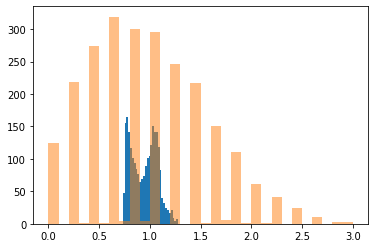

In [ ]:
import matplotlib.pyplot as plt

plt.hist(predictions, bins=30)
plt.hist(target, bins=30, alpha=0.5)
plt.show()

In [ ]:
print(min(preds))
print(max(preds))
rounded_preds = np.round_(preds, decimals=1)
print(min(rounded_preds))
print(max(rounded_preds))

0.73230493
1.2782159
0.7
1.3


###### Get the final RMSE for all the training data

In [ ]:
train_dataset = Task1Dataset(train_X, train_df['meanGrade'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

In [ ]:
predictions_t, targets_t = model_eval(train_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


[0.76395303 1.0368106  0.8054189  ... 0.7708231  1.0429242  0.9800718 ] [0.2 1.6 1.  ... 0.6 1.4 0.4]
| MSE: 0.32 | RMSE: 0.56 |


##### Visualise the results of evaluation

In [ ]:
train_results = pd.DataFrame({'predictions': predictions_t, 'target': targets_t})

In [ ]:
test_results = pd.DataFrame({'predictions': predictions, 'target': target})

Text(0.5, 1.0, 'Test Predictions')

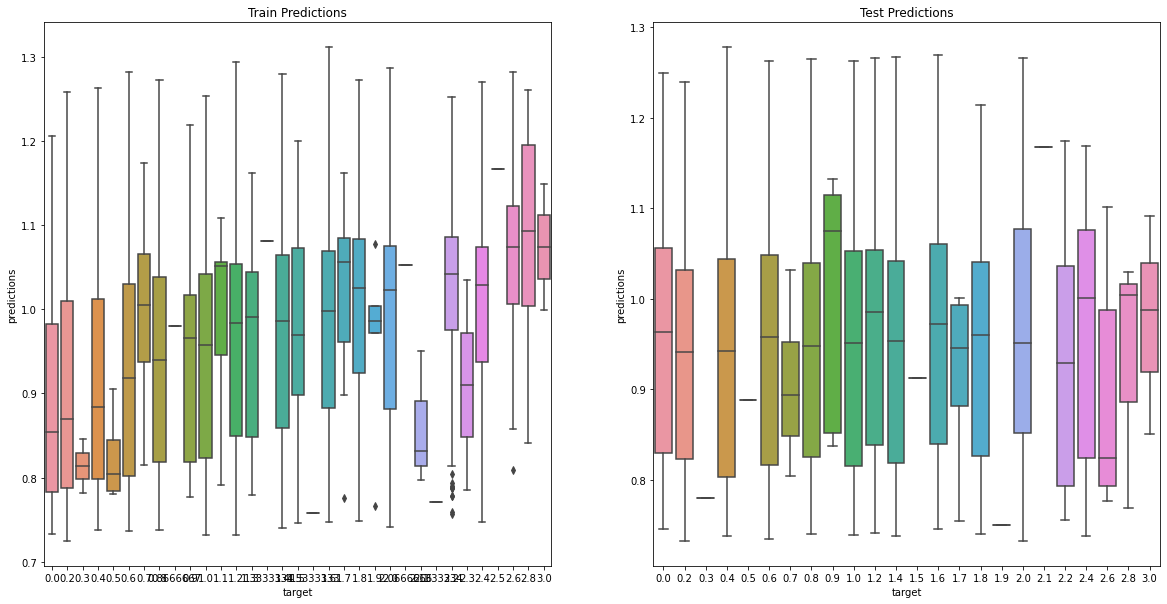

In [ ]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))



sns.boxplot(x='target', y='predictions', data=train_results, ax=ax1)
sns.boxplot(x='target', y='predictions', data=test_results, ax=ax2)
ax1.set_title('Train Predictions')
ax2.set_title('Test Predictions')

In [ ]:
test_results.to_csv(drive_dir + 'test_results_bert.csv')

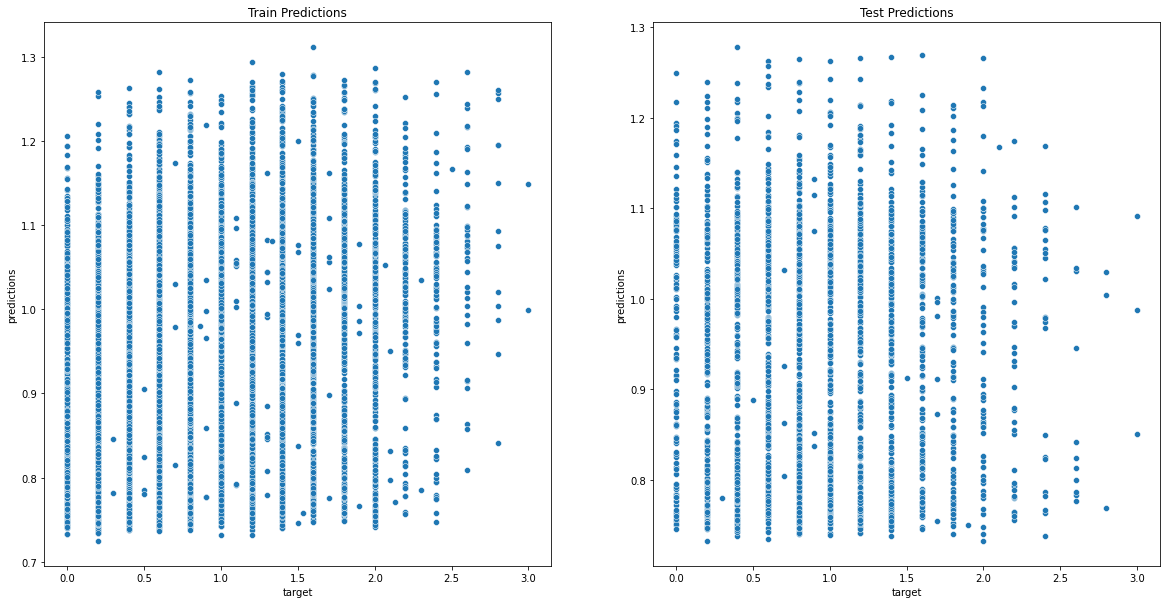

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

 

sns.scatterplot(x='target', y='predictions', data=train_results, ax=ax1)
sns.scatterplot(x='target', y='predictions', data=test_results, ax=ax2)
ax1.set_title('Train Predictions')
ax2.set_title('Test Predictions')

 

plt.show()